In [9]:

import numpy as np
import matplotlib.pyplot as plt
import h5py
from scipy import optimize
from scipy import signal
from scipy import interpolate
# from scipy.signal.signaltools import choose_conv_method


# %matplotlib notebook
# plt.rcParams['figure.figsize'] = (6.4, 4.8)
%matplotlib widget

## Data preset

In [10]:
Atom = "Fe"
Path = r"C:\Researches\Data\MPS3\202103_2"
energyDispersion = 1  # eV
refElasticPixel = 4000

In [39]:
def make_filename(scanNumber):
    global Atom
    if scanNumber < 10:
        fileName = Atom + "_" + "000" + str(scanNumber)
    elif scanNumber < 100:
        fileName = Atom + "_" + "00" + str(scanNumber)
    elif scanNumber < 1000:
        fileName = Atom + "_" + "0" + str(scanNumber)
    else:
        fileName = Atom + "_" + str(scanNumber)
    return fileName

def gaussian_amp(x,xc,fwhm,amp):
    return amp*np.exp(-4*np.log(2)*(x-xc)**2/(fwhm)**2)

def elastic_shift(xAxis,uncorrData,zeroType,peakHeight,peakWidth):
    global refElasticPixel
    if zeroType == "peak":
        peaks, properties = signal.find_peaks(
            uncorrData, height=peakHeight, width=peakWidth
        )
        peakHeight = properties["peak_heights"][-1]
    elif zeroType == "height":
        peaks = xAxis[(uncorrData>peakHeight)]
    else:
        peaks = [refElasticPixel]
    uncorrData= np.roll(uncorrData, refElasticPixel - peaks[-1])
    popt, pcov = optimize.curve_fit(
        gaussian_amp,
        xAxis[(xAxis>refElasticPixel-70)&(xAxis<refElasticPixel+70)],
        uncorrData[(xAxis>refElasticPixel-70)&(xAxis<refElasticPixel+70)],
        p0=[refElasticPixel, 10, peakHeight],
    )
    corrData= np.roll(uncorrData, refElasticPixel - round(popt[0]))[::-1]
    corrAxis = np.array(popt[0]-round(popt[0]) + refElasticPixel - xAxis)[::-1]
    return corrAxis,corrData

# def corr_xaxis(refData, uncorrData):
#     corr = signal.correlate(refData, uncorrData)  # consider full pattern
#     lags = signal.correlation_lags(len(refData), len(uncorrData))
#     lag = lags[np.argmax(corr)]

#     # elastic corr
#     uncorrData = np.roll(uncorrData, lag)
#     peaks, _ = signal.find_peaks(
#         refData, height=np.max(refData) / 20, width=3
#     )
#     corr = signal.correlate(refData[peaks[-1]-50:peaks[-1]+50], uncorrData[peaks[-1]-50:peaks[-1]+50]) 
#     lags = signal.correlation_lags(len(refData[peaks[-1]-50:peaks[-1]+50]), len(uncorrData[peaks[-1]-50:peaks[-1]+50]))
#     lag = lags[np.argmax(corr)]

#     corrData = np.roll(uncorrData, lag)
#     return corrData

def corr_xaxis(refData, uncorrData):

    xAxis = np.arange(len(refData))
    xAxisNew = np.arange(0,len(refData)-1,0.1)
    f1 = interpolate.interp1d(xAxis,refData,kind='linear',fill_value="extrapolate")
    f2 = interpolate.interp1d(xAxis,uncorrData,kind='linear',fill_value="extrapolate")

    refInt = f1(xAxisNew)
    uncorrInt = f2(xAxisNew)

    corr = signal.correlate(refInt, uncorrInt)  # consider full pattern
    lags = signal.correlation_lags(len(refInt), len(uncorrInt))
    lag = lags[np.argmax(corr)]

    # elastic corr
    uncorrInt = np.roll(uncorrInt, lag)
    peaks, _ = signal.find_peaks(
        refInt, height=np.max(refInt)/5 , width=3
    )
    corr = signal.correlate(refInt[peaks[-1]-1000:peaks[-1]+500], uncorrInt[peaks[-1]-1000:peaks[-1]+500]) 
    lags = signal.correlation_lags(len(refInt[peaks[-1]-1000:peaks[-1]+500]), len(uncorrInt[peaks[-1]-1000:peaks[-1]+500]))
    lag = lags[np.argmax(corr)]

    corrInt = np.roll(uncorrInt, lag)

    f3 = interpolate.interp1d(xAxisNew,corrInt,kind='linear',fill_value="extrapolate")

    corrData = f3(xAxis)
    return corrData

def trans_energy(rawData,zeroType,peakHeight,peakWidth):
    global energyDispersion
    pixel = np.arange(len(rawData))
    pixelAxis,pixelData = elastic_shift(pixel,rawData,zeroType,peakHeight,peakWidth)
    energyAxis = np.array(pixelAxis * energyDispersion)
    return energyAxis,pixelData

def get_data(scanNumber):
    global Path
    f1 = h5py.File(Path + "\\RIXS\\" + make_filename(scanNumber) + "_d1.h5", "r")
    f2 = h5py.File(Path + "\\RIXS\\" + make_filename(scanNumber) + "_d2.h5", "r")
    f3 = h5py.File(Path + "\\RIXS\\" + make_filename(scanNumber) + "_d3.h5", "r")
    ccd1 = f1["entry"]["analysis"]["spectrum"][()]
    ccd2 = f2["entry"]["analysis"]["spectrum"][()]
    ccd3 = f3["entry"]["analysis"]["spectrum"][()]
    acqTime1 = np.mean(f1["entry"]["instrument"]["NDAttributes"]["AcquireTime"][()])
    acqTime2 = np.mean(f2["entry"]["instrument"]["NDAttributes"]["AcquireTime"][()])
    acqTime3 = np.mean(f3["entry"]["instrument"]["NDAttributes"]["AcquireTime"][()])
    ccd = (corr_xaxis(ccd2, ccd1) + ccd2 + corr_xaxis(ccd2, ccd3)) / 3
    acqTime = (acqTime1 + acqTime2 + acqTime3) / 3
    return ccd, acqTime


def combine_data(scans,zeroType='peak',peakHeight=10,peakWidth=20):
    refData, totalTime = get_data(scans[0])
    data = refData
    for x in scans[1:]:
        tempData, oneTime = get_data(x)
        data = data + corr_xaxis(refData, tempData)
        totalTime = totalTime + oneTime
    pixelData = data / totalTime * 300  # normalize to 5 minutes
    energyAxis,energyData = trans_energy(pixelData,zeroType,peakHeight,peakWidth)
    return [energyAxis,energyData]

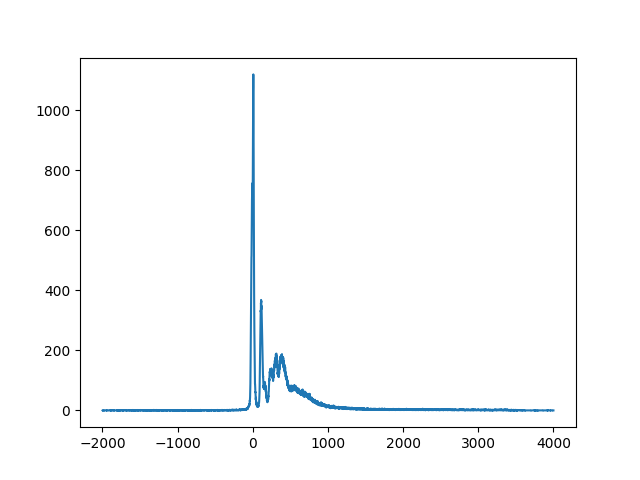

In [40]:
fig = plt.figure()
[X,Y]=combine_data([18])   #scan number
plt.plot(X,Y)
# plt.xlim([-50,50])
# print(X)
# print(Y)

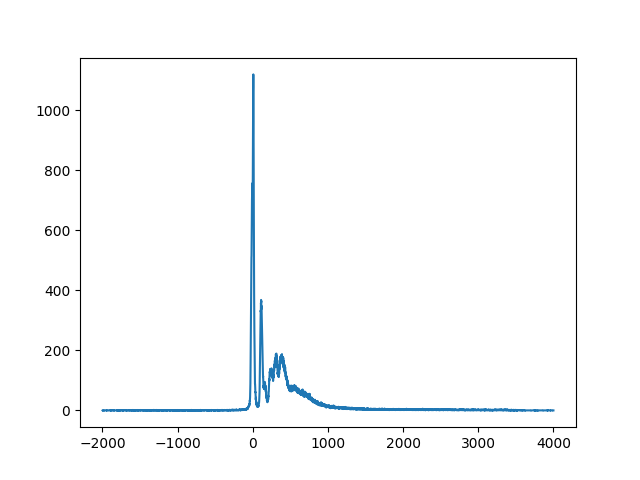

In [43]:
fig = plt.figure()
[X,Y]=combine_data([18],zeroType='height',peakHeight=800)   #scan number
plt.plot(X,Y)

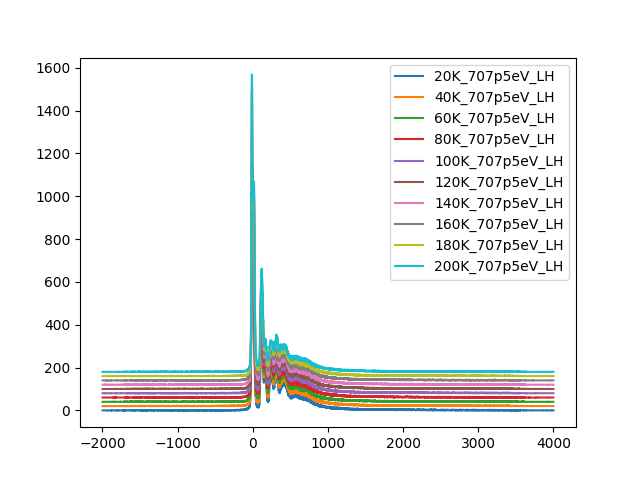

In [ ]:
# %%
fig = plt.figure()

zipLog = {
    "20K_707p5eV_LH": [24],
    "40K_707p5eV_LH": [34],
    "60K_707p5eV_LH": [42],
    "80K_707p5eV_LH": [50],
    "100K_707p5eV_LH": [58],
    "120K_707p5eV_LH": [66],
    "140K_707p5eV_LH": [74],
    "160K_707p5eV_LH": [82],
    "180K_707p5eV_LH": [90],
    "200K_707p5eV_LH": [98],
}

for i, key in enumerate(zipLog):
    [X,Y]=combine_data(zipLog[key])
    plt.plot(X,Y+i*20,label=key)

# plt.xlim([-401,-398])
plt.legend()


FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = 'C:\Researches\Data\MPS3\202103\RIXS\RIXS\Fe_0188_d1.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

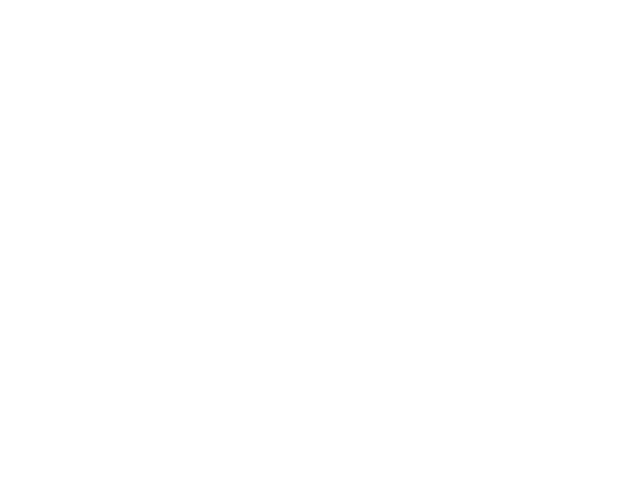

In [ ]:
Path = r"C:\Researches\Data\MPS3\202103\RIXS"

fig = plt.figure()
dataLength = 5900

scans = [x+188 for x in range(12)]
Ei = np.arange(706.75,712.25+0.05,0.1)
eiNum = len(scans)

matrixData = np.zeros(((dataLength+100), eiNum))
matrixEloss = np.zeros(((dataLength+100), eiNum))
matrixEi,_ = np.meshgrid(Ei,np.arange(dataLength+100))

for i,s in enumerate(scans):
    [Eloss,oneData] = combine_data([s])
    matrixData[:,i] = oneData.T
    matrixEloss[:,i] = Eloss.T

plt.pcolor(matrixEi,matrixEloss,matrixData,shading='auto',cmap='jet',vmax=60)
plt.ylim([-0.5,4])
plt.xlabel('Incident Energy (eV)')
plt.ylabel('Energy Loss (eV)')
plt.title('Energy map')

In [ ]:
# def gauss_norm(x,xc,sigma,area):
#     norm = 1./sigma/2/np.sqrt(np.pi/2)
#     return area*norm*np.exp(-2*(x-xc)**2/(sigma*2)**2)

# def gaussian_norm(x,xc,fwhm,area):
#     norm = 1./fwhm/np.sqrt(np.pi/4/np.log(2))
#     return area*norm*np.exp(-4*np.log(2)*(x-xc)**2/(fwhm)**2)

# def gauss_amp(x,xc,sigma,amp):
#     return amp*np.exp(-2*(x-xc)**2/(sigma*2)**2)

# def gaussian_amp(x,xc,fwhm,amp):
#     return amp*np.exp(-4*np.log(2)*(x-xc)**2/(fwhm)**2)

# def lorentz_norm(x,xc,fwhm,area):
#     return 2*area/np.pi*fwhm/(4*(x-xc)**2+fwhm**2)

# def lorentz_amp(x,xc,fwhm,amp):
#     area = amp*fwhm*np.pi/2
#     return 2*area/np.pi*fwhm/(4*(x-xc)**2+fwhm**2)

# def Psd_Voigt(x, xc, area, w, mu):
#     return area * (
#         mu * 2 / np.pi * w / (4 * (x - xc) ** 2 + w ** 2)
#         + (1 - mu)
#         * np.sqrt(4 * np.log(2.0))
#         / np.sqrt(np.pi)
#         / w
#         * np.exp(-4 * np.log(2.0) * (x - xc) ** 2 / w ** 2)
#     )


# from scipy.special import voigt_profile
# voigt_profile(x, sigma, gamma, out=None) = <ufunc 'voigt_profile'>

In [ ]:
def three_gaussian(x, y0, gamma, mu, amp, mu1, amp1, mu2, amp2):
    return (
        y0
        + gaussian_amp(x, mu, gamma, amp)
        + gaussian_amp(x, mu1, gamma, amp1)
        + gaussian_amp(x, mu2, gamma, amp2)
    )


def fit_peaks(xdata, ydata, param_p0, param_bounds):
    popt, pcov = optimize.curve_fit(
        three_gaussian, xdata, ydata, p0=param_p0, bounds=param_bounds
    )
    return popt


def fix_lines(scans):

    energyData = combine_data(scans)

    X = energyData[0, (refElasticPixel - 90) : (refElasticPixel + 90)]
    Y = energyData[1, (refElasticPixel - 90) : (refElasticPixel + 90)]

    param_p0 = [0, 0.08, -0.16, 99, -0.07, 138, 0.054, 141]
    param_down = [0, -0.01, -0.1, -99, -0.1, -138, -0.1, -141]
    param_up = [10, 0.01, 0.1, np.inf, 0.1, np.inf, 0.1, np.inf]
    param_bounds = (
        np.array(param_p0) + np.array(param_down),
        np.array(param_p0) + np.array(param_up),
    )

    popt = fit_peaks(X, Y, param_p0, param_bounds)
    # print(popt)
    energyData[0, :] = energyData[0, :] - popt[2]
    # plt.plot(energyData[0, :], energyData[1, :])

    # f = open(myPath + "\\Analysis\\" + key + ".dat", "w")
    # np.savetxt(f, energyData.T, delimiter="\t")
    # f.close()

    return energyData